In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../module/')

import keras2
from keras2.models import Model
from keras2.layers import concatenate, Dense, Input, Flatten
from keras2.optimizers import Adam
from util import moving_average, dlqr, discretized_system, lqr
import gym2
from rl2.agents import selfDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.
Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
dt = 0.05
env = gym2.make("Pendulum-v1", dt)
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
control_interval = 1

# 取りうる”打ち手”のアクション数と値の定義
nb_actios = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(2, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = selfDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [5]:
#safe learning
l = 0.1
step = 80000
episode_step = int(200 * 0.05 / (dt * control_interval)) # 入力が加えられる回数を200(dt=0.05)にする
a = agent((2,), (2,))
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
# a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
# a.load_weights('../../learned_models_stab/lqr_optimal_agent.h5')
out = a.fit(env, l=l, nb_steps=step, visualize=0, verbose=1, nb_max_episode_steps=episode_step, action_repetition=control_interval)

episode_rewards = out.history['episode_reward']







Training for 80000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 106s 11ms/step - reward: -2.9329
50 episodes - episode_reward: -586.572 [-1278.813, -404.330] - loss: 5.180 - mean_absolute_error: 2.170 - mean_q: -20.100

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 113s 11ms/step - reward: -2.7575
50 episodes - episode_reward: -551.507 [-590.320, -484.616] - loss: 23.493 - mean_absolute_error: 5.023 - mean_q: -43.116

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 87s 9ms/step - reward: -2.7441
50 episodes - episode_reward: -548.829 [-592.036, -473.054] - loss: 47.010 - mean_absolute_error: 7.077 - mean_q: -62.956

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 74s 7ms/step - reward: -2.7291
50 episodes - episode_reward: -545.823 [-597.796, -476.453] - loss: 68.360 - mean_absolute_error: 8.524 - mean_q: -80.078

Interval 5 (40000 ste

In [9]:
a.test(env, l=l, visualize=0, nb_max_episode_steps=episode_step, action_repetition=control_interval)

Testing for 1 episodes ...
Episode 1: reward: 5485.918, steps: 200


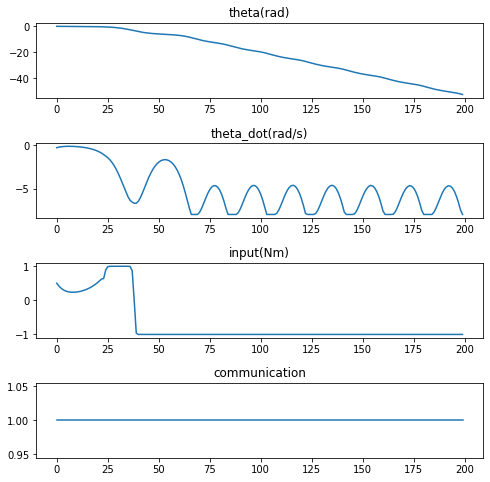

In [10]:
titles = ['theta(rad)', 'theta_dot(rad/s)', 'input(Nm)', 'communication'] 
history = a.data_log[0]
x_axis = range(history.shape[0])
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(history.shape[1]):
    data = history[:,i]
    plt.subplot(history.shape[1],1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

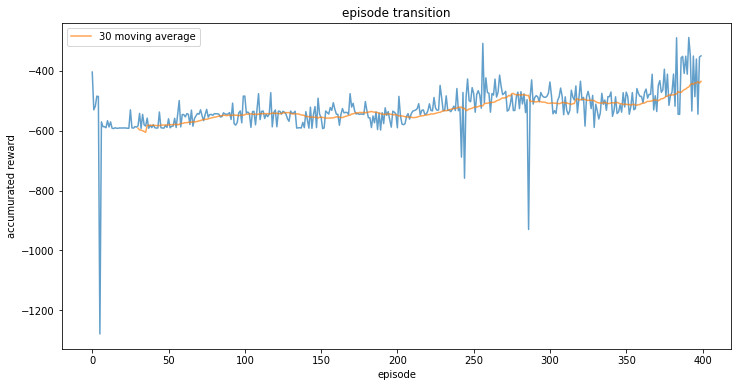

In [6]:
l = 30
plt.figure(figsize=(12,6))
ma = moving_average(episode_rewards, l)
plt.plot(range(len(episode_rewards)), episode_rewards, alpha=0.7)
plt.plot(range(l, len(episode_rewards)), ma, label=f'{l} moving average', alpha=0.7)
plt.xlabel('episode')
plt.ylabel('accumurated reward')
plt.title('episode transition')
plt.legend()
plt.show()